Possible workflow
==========

Proposed by Justin
1. Create substructure sign. (topics) from a fragmentation file.
2. Store into database the topics with related fragments above a certain probability cut-off.
3. Curate/annotate database (this can be done by any chemist/metabolomics researcher in principle)
4. Create substructure sign. from other sample type fragmentation file.
5. Compare to those present in database - add novel ones to database - run substructure sign. from database over file.
6. Then return for each fragmented peak in the file of interest the top 5 or so topic matches with a probability score.
7. The user can look up compounds with similar topics or select and check compounds based on behavior in the dataset.
8. Also, I can check if topics are in any way related to pathways....
9. Compare annotation of compounds to matching with database spectra (pros, cons)

I think such an approach would be publishable in Anal Chem.

The nice thing is that everybody is able to enrich the database with their own samples - and get something back from the already 'curated' substructure signatures. Also, it produces probabilities as to if certain substructures are present in the data/compounds, which is something many people like to publish along with their results.  

In [48]:
import numpy as np
import pandas as pd
import lda
import lda.datasets
import pylab as plt
%matplotlib inline

# beer, urine, CampyTop10Pos, Urine94
results_prefix = 'Urine94'
binary = False
if not binary:
    results_prefix += "_multinomial"

<p>Note that X needs to be DOCUMENTS x WORDS</p>

In [49]:
if 'beer' in results_prefix:
    filename = 'QC_Beer_ParentsFragments_Tonyscripting.csv'
elif 'urine' in results_prefix:
    filename = 'Urine_FragmentsParents_MS2filter5000_Tonyscripting.csv'
elif 'CampyTop10Pos' in results_prefix:
    filename = 'ParentFragmentMatrix_CampyTop10Pos.csv'
elif 'Urine94' in results_prefix:
    filename = 'ParentFragmentMatrix_Urine94_mixed.csv'
    
print filename
data = pd.read_csv(filename,index_col=0)

ParentFragmentMatrix_Urine94_mixed.csv


Multinomial


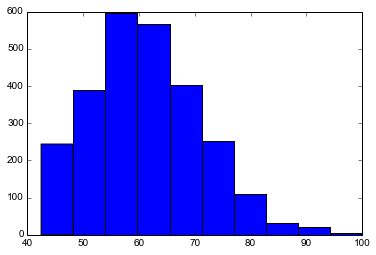

In [50]:
if binary:
    print "Binary"
    data = data.replace(np.nan,0)
    data[data>0] = 1
    data = data.transpose()
    print data.shape
    npdata = np.array(data,dtype='int64')
else:
    print "Multinomial"
    data = np.log(data)
    min_val = data.min().min()
    data /= data.max().max()
    data *= 100
    from scipy.sparse import coo_matrix
    data = data.replace(np.nan,0)
    data = data.transpose()
    sd = coo_matrix(data)
    plt.hist(sd.data)
    sd = sd.floor()  
    npdata = np.array(sd.todense(),dtype='int64')

In [51]:
n_topics = 50

In [52]:
model = lda.LDA(n_topics = n_topics, n_iter=1000, random_state=1)

In [53]:
model.fit(npdata)

<lda.lda.LDA instance at 0x7f30f0b6b9e0>

In [54]:
topic_fragments = model.topic_word_
n_top_frags = 20
with open(results_prefix + 'topics.csv','w') as f:
    for i,topic_dist in enumerate(topic_fragments):
        topic_f = np.array(data.columns.values)[np.argsort(topic_dist)][:-n_top_frags:-1]
        out_string = 'Topic {},{}'.format(i, ','.join(topic_f.astype('str')))
        print(out_string)
        f.write(out_string+'\n')
        

Topic 0,84.04438,56.04983,130.04995,102.05488,85.02844,88.03927,60.04468,141.01804,112.03911,114.03734,87.06335,107.08538,135.11699,153.12737,101.07101,90.05481,165.09047,59.04942,107.04911
Topic 1,82.06515,128.07063,74.02369,100.07559,56.04983,88.03927,134.04484,130.04995,70.02884,67.04171,116.03416,163.10757,131.12941,98.06006,113.07874,158.04497,83.07286,150.0743,122.07922
Topic 2,84.0808,85.08391,131.08953,72.04441,56.04983,85.07819,130.08608,68.05762,81.04545,99.04253,72.00861,114.09158,60.04468,93.04567,86.06004,137.03578,146.03783,67.02963,57.04497
Topic 3,59.06872,58.06537,101.07917,85.08391,103.05818,59.06236,60.07669,89.07908,88.07569,138.05489,144.06535,127.09459,89.00629,89.07294,70.99563,71.06857,61.07814,84.04503,76.96974
Topic 4,74.02427,84.04503,128.03554,127.05133,145.06219,101.07197,109.04083,82.02939,58.02917,125.03555,98.02451,107.02495,156.03004,88.04008,59.97087,101.07164,119.0172,130.05122,115.00334
Topic 5,506.83144,312.91379,72.00861,188.93943,294.90305,206.950

<p>Output in a fragments x topics matrix of probabilities - almost certainly an easier way of doing this, but I'm enjoying playing with PANDAS data structures..</p>

In [55]:
topic = model.topic_word_
masses = np.array(data.transpose().index)
d = {}
for i in np.arange(n_topics):
    topic_name = i
    topic_series = pd.Series(topic[i],index=masses)
    d[topic_name] = topic_series
topicdf = pd.DataFrame(d)


In [56]:
topicdf.to_csv(results_prefix+'all.csv')
print results_prefix+'all.csv'

Urine94_multinomialall.csv


In [57]:
doc = model.doc_topic_
(n_doc,a) = doc.shape

In [58]:
topic_index = np.arange(n_topics)
doc_names = np.array(data.index)
d = {}
for i in np.arange(n_doc):
    doc_name = doc_names[i]
    doc_series = pd.Series(doc[i],index=topic_index)
    d[doc_name] = doc_series
docdf = pd.DataFrame(d)
cols = docdf.columns.tolist()
mass_rt = [(float(m.split('_')[0]),float(m.split('_')[1])) for m in cols]
sorted_mass_rt = sorted(mass_rt,key=lambda m:m[0])
ind = [mass_rt.index(i) for i in sorted_mass_rt]
docdf = docdf[ind]


In [59]:
docdf.to_csv(results_prefix+'docs.csv')

In [60]:

print data.index

Index([u'74.05411_652.092', u'87.04479_554.696', u'91.05329_282.39', u'94.06497_916.93', u'96.96933_642.456', u'96.96066_683.483', u'98.96874_598.554', u'100.04951_560.383', u'100.98536_1203.52', u'101.07058_627.202', u'102.09127_876.482', u'104.10699_846.666', u'104.07002_550.857', u'105.01998_531.775', u'105.10976_846.666', u'106.08393_524.152', u'108.08046_876.482', u'109.07586_947.378', u'110.07139_615.704', u'110.04978_484.008', u'110.9644_431', u'111.03191_478.319', u'111.01511_274.698', u'115.06838_487.788', u'115.03728_531.775', u'116.03915_661.862', u'116.10693_756.571', u'116.95958_1254.1', u'117.02062_606.206', u'117.05565_410.199', u'117.10815_756.571', u'118.08625_526.042', u'118.06075_661.862', u'119.0349_482.122', u'119.05213_531.775', u'120.0651_613.818', u'121.02888_465.044', u'121.07128_533.66', u'122.02594_615.704', u'122.07313_535.545', u'122.96812_1203.52', u'124.00749_634.882', u'126.02098_634.882', u'126.01986_489.709', u'127.03409_527.979', u'127.04202_629.159',